In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
import pandas as pd
from collections import Counter
import plotly.express as px
from tensorflow import keras
from numba import jit
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelmin
from scipy.stats import entropy
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pickle
from tqdm import tqdm
import math
from joblib import Parallel, delayed
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelmin


print("Done!")


Done!


Load data
---



In [2]:
#Example: Load data frame with Pickle
path_to_data = "C:/Users/ ..... /df_chr22_012.pkl"

with open(path_to_data, 'rb') as f:
    df_012 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/ ..... /df_chr22_012.pkl'

In [2]:
#If no real data is available use this test data - You will however, get better results with real data
num_rows = 1000
num_cols = 100

# Erstellen eines DataFrames mit zufälligen Nullen, Einsen und Zweien
data = np.random.choice([0, 1, 2], size=(num_rows, num_cols))
df_012 = pd.DataFrame(data, columns=[f'Individuum {i}' for i in range(num_cols)], index=[f'SNP {i}' for i in range(num_rows)])



Have a look at the data
---



In [3]:
df_012

,Individuum 0,Individuum 1,Individuum 2,Individuum 3,Individuum 4,Individuum 5,Individuum 6,Individuum 7,Individuum 8,Individuum 9,...,Individuum 90,Individuum 91,Individuum 92,Individuum 93,Individuum 94,Individuum 95,Individuum 96,Individuum 97,Individuum 98,Individuum 99
SNP 0,2,1,1,1,1,1,0,0,1,2,...,2,0,2,2,2,0,1,1,1,2
SNP 1,2,2,2,2,1,1,1,2,0,2,...,0,1,2,0,0,2,1,2,2,2
SNP 2,0,1,2,2,0,0,0,0,2,2,...,0,1,1,0,1,0,2,2,1,0
SNP 3,2,1,1,2,2,2,0,1,0,0,...,1,1,2,0,1,2,2,0,1,0
SNP 4,0,0,2,2,1,2,1,1,0,2,...,1,2,2,1,0,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP 995,2,0,1,1,0,1,0,2,2,2,...,1,0,0,0,1,0,0,1,0,0
SNP 996,0,2,2,0,1,0,1,2,2,0,...,1,1,0,2,2,1,2,0,1,1
SNP 997,1,2,1,1,0,0,1,1,0,2,...,0,1,1,1,0,1,0,1,2,0
SNP 998,0,0,0,1,1,0,0,1,1,2,...,2,0,1,0,0,2,0,0,1,1


Method 1:Split data frame into same size parts
---



In [28]:
def split_dataframe(df, block_length):
    num_blocks = len(df) // block_length
    remainder = len(df) % block_length
    block_indices = np.arange(0, num_blocks * block_length, block_length)


    blocks = [df.iloc[i:i + block_length] for i in block_indices]

    # if the are remains thy became there own segment
    if remainder:
        blocks.append(df.iloc[num_blocks * block_length:])

    return blocks

In [29]:
#Split data frame into parts of size 100
segment_size = 100

dataframes = split_dataframe(df_012,segment_size)
total_length = 0
for i in range(len(dataframes)):
  print("Segment ",i," has a lenght of ",len(dataframes[i]))
  total_length = total_length +len(dataframes[i])

print("")
print("With a total length of", total_length)

Segment  0  has a lenght of  100
Segment  1  has a lenght of  100
Segment  2  has a lenght of  100
Segment  3  has a lenght of  100
Segment  4  has a lenght of  100
Segment  5  has a lenght of  100
Segment  6  has a lenght of  100
Segment  7  has a lenght of  100
Segment  8  has a lenght of  100
Segment  9  has a lenght of  100

With a total length of 1000


Method 2: Split by correlation
---



<ipython-input-4-ac520cc280f2>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)
/usr/local/lib/python3.10/dist-packages/numba/core/typed_passes.py:334: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "<ipython-input-4-ac520cc280f2>", line 3:
@jit(parallel=True)
def compute_correlation_matrix(data):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


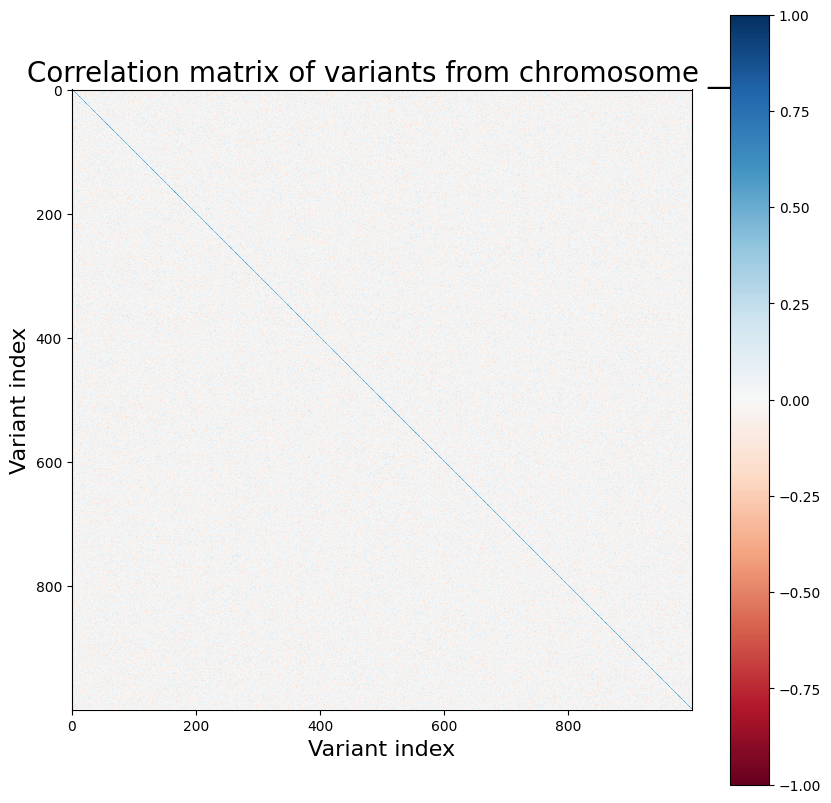

In [4]:
#Generat correlation matrix
@jit(parallel=True)
def compute_correlation_matrix(data):
    return np.corrcoef(data)


correlation_matrix = compute_correlation_matrix(df_012.values)


plt.figure(figsize=(10, 10))
cmap = plt.cm.RdBu

plt.imshow(correlation_matrix, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar()


plt.title('Correlation matrix of variants from chromosome __', fontsize=20)
plt.xlabel('Variant index', fontsize=16)
plt.ylabel('Variant index', fontsize=16)

plt.show()

In [5]:
#calculate aggregated correlation for segmentation

threshould = 0.1 # this is the noise floor we found works fine for real data

def antidiagonal_sum(matrix, row, col):
    size = len(matrix)
    diagonal_sum = 0

    for i in range(size):
        j = row + col - i
        if j >= 0 and j < size:
            if np.abs(matrix[i][j]) > threshould:
                diagonal_sum += np.abs(matrix[i][j])

    return diagonal_sum

def calculate_antidiagonal_sums(matrix):
    results = Parallel(n_jobs=-1)(delayed(antidiagonal_sum)(matrix, i, i) for i in range(len(matrix)))
    return results




results = calculate_antidiagonal_sums(correlation_matrix)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


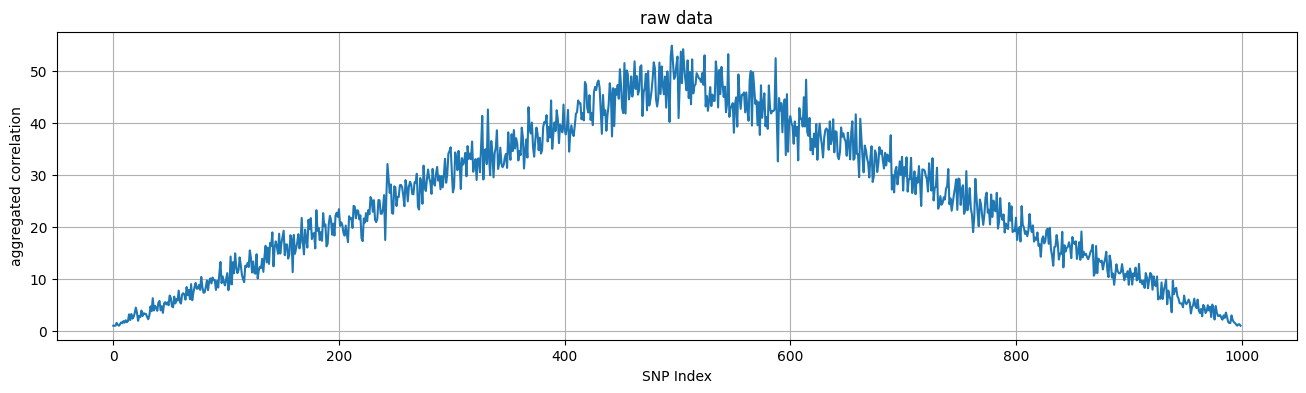

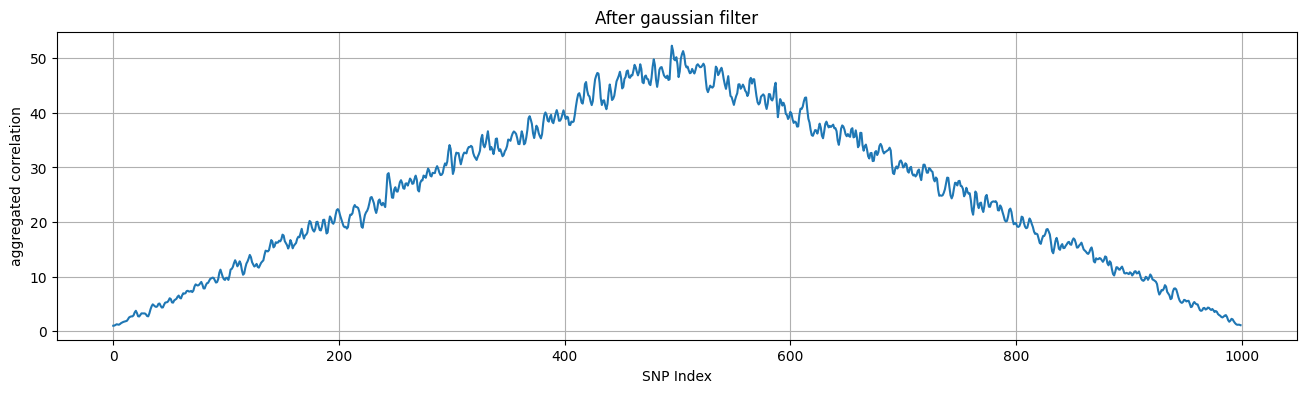

In [6]:
#plot result

#artificial data produces a pyramid , this nicely illustrates why we use a threshold for the real data with a threshold

plt.figure(figsize=(16, 4))
plt.plot(results)
plt.xlabel('SNP Index')
plt.ylabel('aggregated correlation')
plt.title('raw data')
plt.grid(True)
plt.show()




smoothed_result = gaussian_filter1d(results, sigma=1)

plt.figure(figsize=(16, 4))
plt.plot(smoothed_result)

plt.xlabel('SNP Index')
plt.ylabel('aggregated correlation')
plt.title('After gaussian filter')
plt.grid(True)
plt.show()

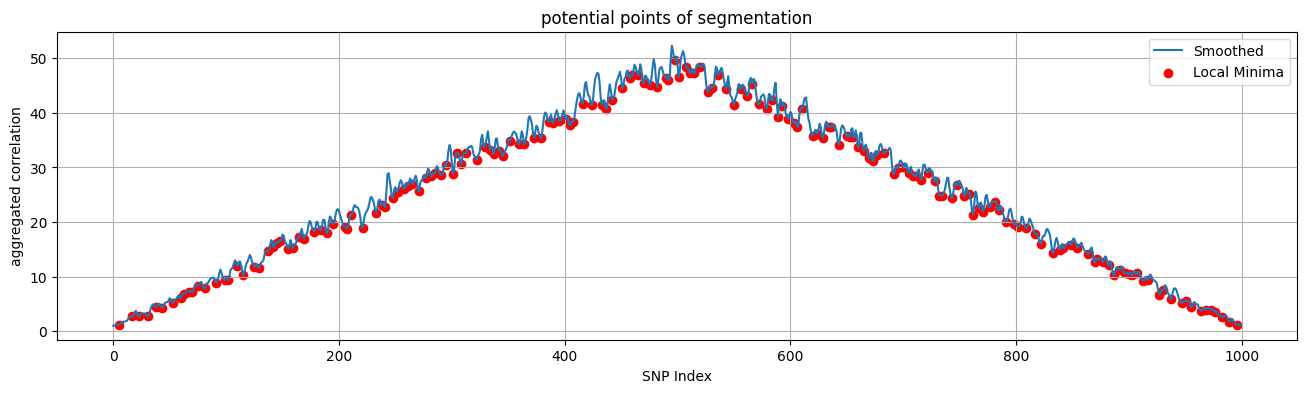

In [7]:
#find local minimum



smoothed_result = gaussian_filter1d(results, sigma=1)

local_minima_indices = argrelmin(smoothed_result)[0]


plt.figure(figsize=(16, 4))

plt.plot(smoothed_result, label='Smoothed')
plt.scatter(local_minima_indices, smoothed_result[local_minima_indices], color='red', label='Local Minima')
plt.title('potential points of segmentation')
plt.xlabel('SNP Index')
plt.ylabel('aggregated correlation')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#Find best points for segmentation

segment_size_min = 50#400
segment_size_max = 150#1600

position = 0

segment_positions = []
split_list = []

run = True
j = 0
total_length_covered = 0
while run:
    candidates = []

    for i in range(len(local_minima_indices)):
        if local_minima_indices[i] >= (position + segment_size_min):
            if local_minima_indices[i] <= (position + segment_size_max):
                candidates.append(local_minima_indices[i])

    if len(candidates) == 0:
        break

    minimum_x_position = candidates[np.argmin(smoothed_result[candidates])]
    minimum_x_position_y_value = smoothed_result[minimum_x_position]

    segment_positions.append([position, minimum_x_position])
    print("Segment Nr:", j)
    print("Segment Start/End:", [position, minimum_x_position])
    print("Segment length:", minimum_x_position - position)
    total_length_covered += minimum_x_position - position
    print("Total length covered:", total_length_covered)
    print("")
    split_list.append(minimum_x_position)
    position = minimum_x_position + 1
    j += 1

    if position >= len(smoothed_result):
        run = False


if position < len(smoothed_result) and (len(smoothed_result) - position) < segment_size_min:
    segment_positions.append([position, len(smoothed_result) - 1])
    print("Segment Nr:", j)
    print("Segment Start/End:", [position, len(smoothed_result) - 1])
    print("Segment length:", len(smoothed_result) - 1 - position)
    total_length_covered += len(smoothed_result) - 1 - position
    print("Total length covered:", total_length_covered)

Segment Nr: 0
Segment Start/End: [0, 53]
Segment length: 53
Total length covered: 53

Segment Nr: 1
Segment Start/End: [54, 115]
Segment length: 61
Total length covered: 114

Segment Nr: 2
Segment Start/End: [116, 169]
Segment length: 53
Total length covered: 167

Segment Nr: 3
Segment Start/End: [170, 221]
Segment length: 51
Total length covered: 218

Segment Nr: 4
Segment Start/End: [222, 277]
Segment length: 55
Total length covered: 273

Segment Nr: 5
Segment Start/End: [278, 345]
Segment length: 67
Total length covered: 340

Segment Nr: 6
Segment Start/End: [346, 405]
Segment length: 59
Total length covered: 399

Segment Nr: 7
Segment Start/End: [406, 550]
Segment length: 144
Total length covered: 543

Segment Nr: 8
Segment Start/End: [551, 692]
Segment length: 141
Total length covered: 684

Segment Nr: 9
Segment Start/End: [693, 833]
Segment length: 140
Total length covered: 824

Segment Nr: 10
Segment Start/End: [834, 983]
Segment length: 149
Total length covered: 973

Segment Nr

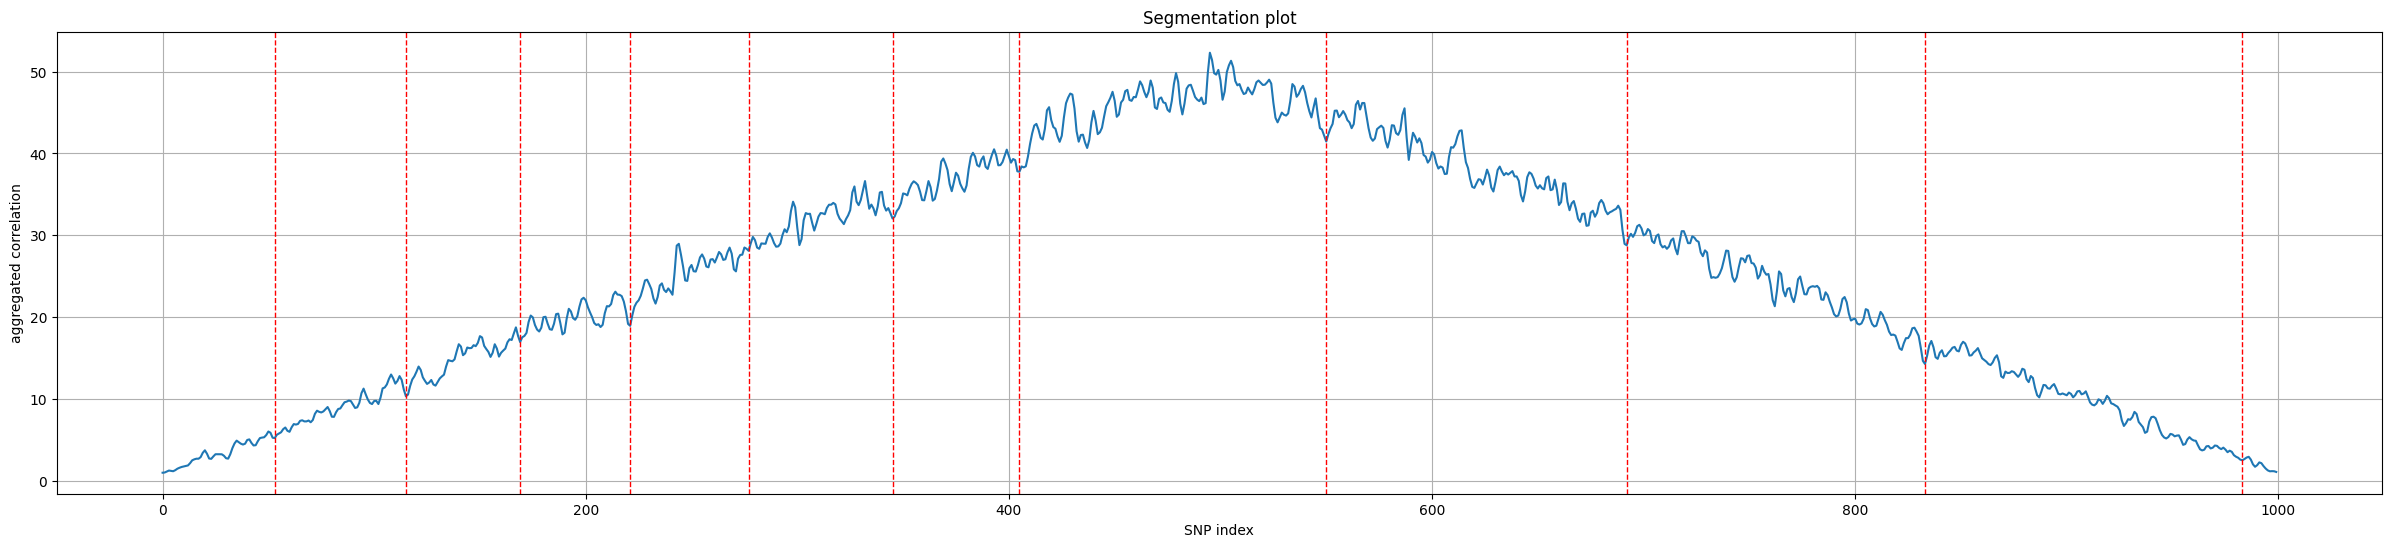

In [9]:
# plot the segmentation
plt.figure(figsize=(30, 6))

plt.plot(smoothed_result )

for x_coord in split_list:
    plt.axvline(x=x_coord, color='r', linestyle='--', linewidth=1 )


plt.title('Segmentation plot')
plt.xlabel('SNP index')
plt.ylabel('aggregated correlation')
#plt.legend()
plt.grid(True)
plt.show()

In [10]:
import pandas as pd

def split_dataframe_by_positions(df, positions):
    """
    Teilt ein DataFrame zeilenweise an den angegebenen Positionen auf.

    Args:
        df (pandas.DataFrame): Das DataFrame, das aufgeteilt werden soll.
        positions (list): Eine Liste von Positionen, an denen das DataFrame aufgeteilt werden soll.

    Returns:
        list von pandas.DataFrame: Eine Liste von DataFrames, die durch das Aufteilen des ursprünglichen DataFrames an den angegebenen Positionen entstanden sind.
    """
    # Sortiere die Positionen, um sicherzustellen, dass sie aufsteigend sind
    positions.sort()

    # Initialisiere die Liste für die aufgeteilten DataFrames
    splitted_dfs = []

    # Startindex für das Aufteilen des DataFrames
    start_index = 0

    # Iteriere über die Positionen und teile das DataFrame entsprechend auf
    for pos in positions:
        # Füge den aufgeteilten Teil des DataFrames zur Liste hinzu
        splitted_dfs.append(df.iloc[start_index:pos])

        # Setze den Startindex für den nächsten Teil
        start_index = pos

    # Füge den letzten Teil des DataFrames zur Liste hinzu
    splitted_dfs.append(df.iloc[start_index:])

    return splitted_dfs

In [11]:
#Split the data frame
dataframes =  []
dataframes = split_dataframe_by_positions(df_012,split_list)

total_lenght_all_segments = 0
start = 0

for dataframe in range(len(dataframes)):

  total_lenght_all_segments = total_lenght_all_segments +len(dataframes[dataframe])
  #print(total_lenght_all_segments)
  print(len(dataframes[dataframe]))

print("total_lenght_all_segments:",total_lenght_all_segments)

53
62
54
52
56
68
60
145
142
141
150
17
total_lenght_all_segments: 1000


Train VAE
---



##############################################
Now training block  0 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


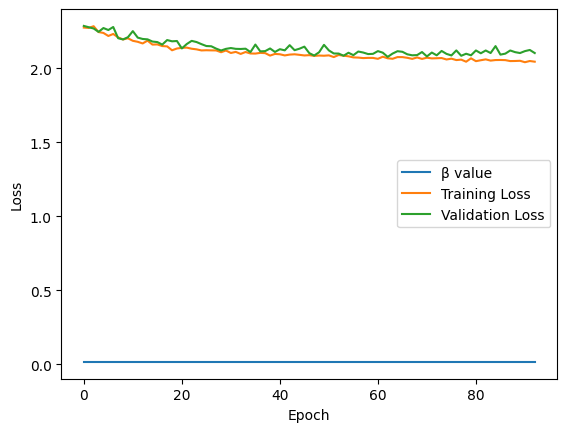

Avarage reconstruction accuracy over 100 runs: 31.99%
KL Divergence on validation data: 0.25796636939048767
KL Divergence on validation data (total): 2.5796637535095215
KL Divergence on validation data (per dimension): [0.14296222 0.34540468 0.14711443 0.20820245 0.23935299 0.3069793
 0.36733264 0.2342002  0.32534677 0.26276818]
KL Divergence on validation data: (2.5796638, array([0.14296222, 0.34540468, 0.14711443, 0.20820245, 0.23935299,
       0.3069793 , 0.36733264, 0.2342002 , 0.32534677, 0.26276818],
      dtype=float32))
##############################################
Now training block  1 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


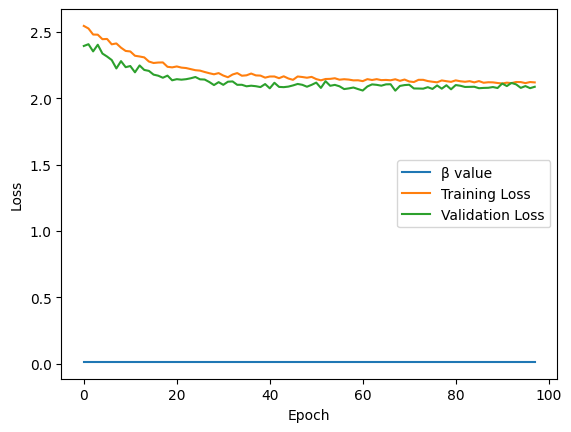

Avarage reconstruction accuracy over 100 runs: 33.48%
KL Divergence on validation data: 0.22136881947517395
KL Divergence on validation data (total): 2.213688373565674
KL Divergence on validation data (per dimension): [0.21711859 0.1494514  0.20166293 0.18904665 0.28811824 0.15983573
 0.23562506 0.22163215 0.39386454 0.15733299]
KL Divergence on validation data: (2.2136884, array([0.21711859, 0.1494514 , 0.20166293, 0.18904665, 0.28811824,
       0.15983573, 0.23562506, 0.22163215, 0.39386454, 0.15733299],
      dtype=float32))
##############################################
Now training block  2 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


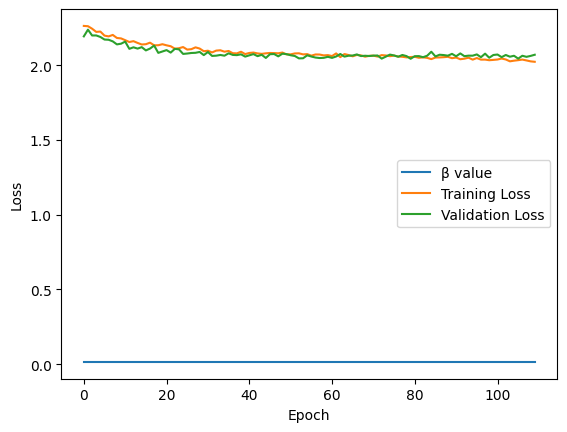

Avarage reconstruction accuracy over 100 runs: 33.60%
KL Divergence on validation data: 0.28639519214630127
KL Divergence on validation data (total): 2.8639519214630127
KL Divergence on validation data (per dimension): [0.3457233  0.25738728 0.25802913 0.27924585 0.22141103 0.3773333
 0.25464612 0.3315992  0.24014464 0.29843214]
KL Divergence on validation data: (2.863952, array([0.3457233 , 0.25738728, 0.25802913, 0.27924585, 0.22141103,
       0.3773333 , 0.25464612, 0.3315992 , 0.24014464, 0.29843214],
      dtype=float32))
##############################################
Now training block  3 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


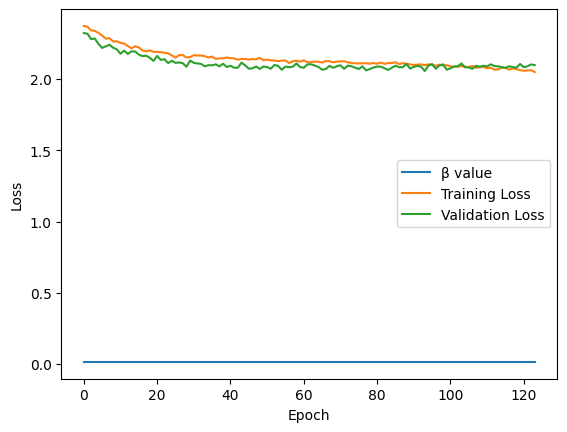

Avarage reconstruction accuracy over 100 runs: 32.96%
KL Divergence on validation data: 0.28669559955596924
KL Divergence on validation data (total): 2.8669559955596924
KL Divergence on validation data (per dimension): [0.23627976 0.18970129 0.515277   0.22002642 0.2876554  0.30097455
 0.24263415 0.25460693 0.35093522 0.2688653 ]
KL Divergence on validation data: (2.866956, array([0.23627976, 0.18970129, 0.515277  , 0.22002642, 0.2876554 ,
       0.30097455, 0.24263415, 0.25460693, 0.35093522, 0.2688653 ],
      dtype=float32))
##############################################
Now training block  4 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


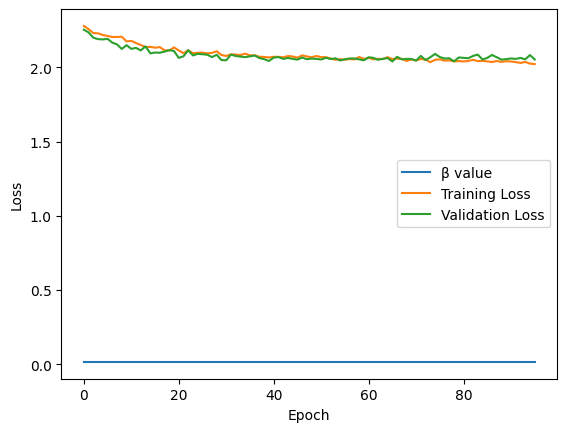

Avarage reconstruction accuracy over 100 runs: 33.16%
KL Divergence on validation data: 0.26425838470458984
KL Divergence on validation data (total): 2.6425838470458984
KL Divergence on validation data (per dimension): [0.1324098  0.15385476 0.42019767 0.22232676 0.38936135 0.27319628
 0.21745804 0.3370103  0.30273414 0.19403489]
KL Divergence on validation data: (2.6425838, array([0.1324098 , 0.15385476, 0.42019767, 0.22232676, 0.38936135,
       0.27319628, 0.21745804, 0.3370103 , 0.30273414, 0.19403489],
      dtype=float32))
##############################################
Now training block  5 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


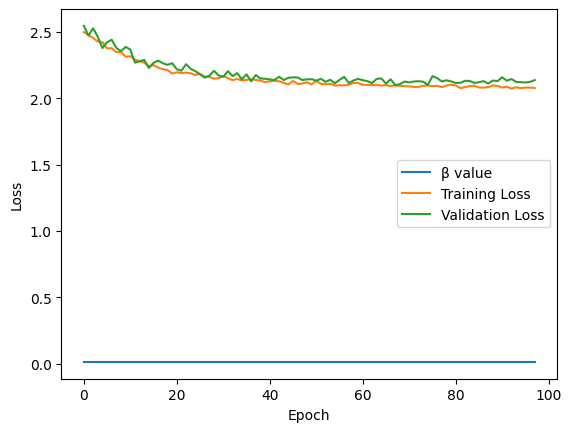

Avarage reconstruction accuracy over 100 runs: 31.17%
KL Divergence on validation data: 0.24387061595916748
KL Divergence on validation data (total): 2.438706159591675
KL Divergence on validation data (per dimension): [0.28126496 0.2320311  0.26192418 0.21558738 0.19315039 0.27442843
 0.2507301  0.17677082 0.26142353 0.2913952 ]
KL Divergence on validation data: (2.4387062, array([0.28126496, 0.2320311 , 0.26192418, 0.21558738, 0.19315039,
       0.27442843, 0.2507301 , 0.17677082, 0.26142353, 0.2913952 ],
      dtype=float32))
##############################################
Now training block  6 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


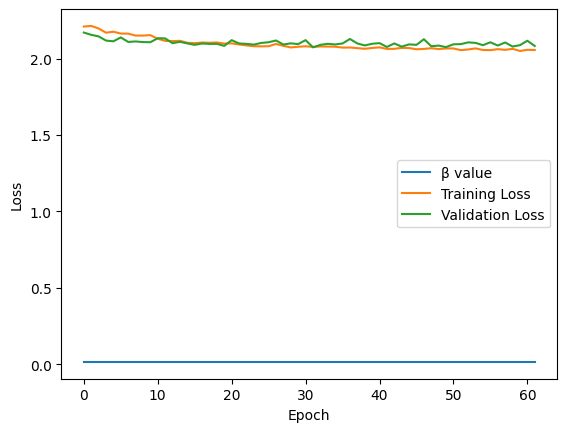

Avarage reconstruction accuracy over 100 runs: 32.77%
KL Divergence on validation data: 0.2903440594673157
KL Divergence on validation data (total): 2.903440475463867
KL Divergence on validation data (per dimension): [0.20263597 0.3378845  0.86136836 0.14258686 0.20888261 0.23935656
 0.19526365 0.17137395 0.1675127  0.3765753 ]
KL Divergence on validation data: (2.9034405, array([0.20263597, 0.3378845 , 0.86136836, 0.14258686, 0.20888261,
       0.23935656, 0.19526365, 0.17137395, 0.1675127 , 0.3765753 ],
      dtype=float32))
##############################################
Now training block  7 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


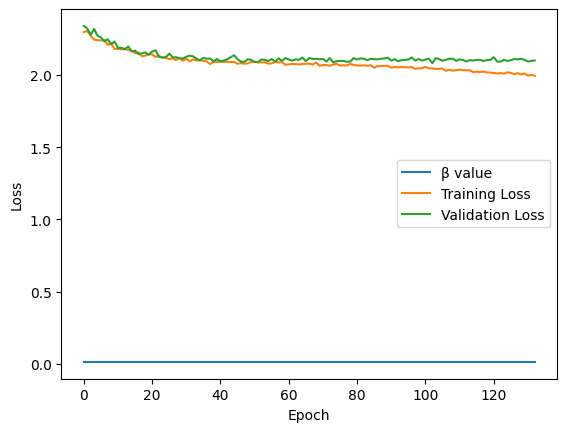

Avarage reconstruction accuracy over 100 runs: 32.07%
KL Divergence on validation data: 0.41522708535194397
KL Divergence on validation data (total): 4.152270793914795
KL Divergence on validation data (per dimension): [0.6105951  0.30022323 0.37021622 0.41427025 0.32440144 0.293707
 0.38288674 0.47656077 0.5369635  0.44244647]
KL Divergence on validation data: (4.152271, array([0.6105951 , 0.30022323, 0.37021622, 0.41427025, 0.32440144,
       0.293707  , 0.38288674, 0.47656077, 0.5369635 , 0.44244647],
      dtype=float32))
##############################################
Now training block  8 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


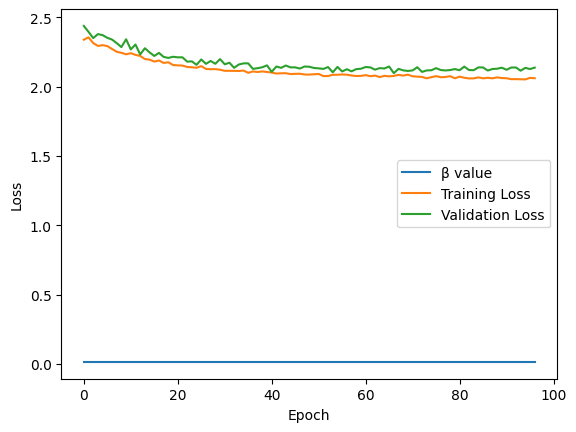

Avarage reconstruction accuracy over 100 runs: 31.91%
KL Divergence on validation data: 0.2790493667125702
KL Divergence on validation data (total): 2.7904934883117676
KL Divergence on validation data (per dimension): [0.28104347 0.2766886  0.18281154 0.18017277 0.42220458 0.3120724
 0.432444   0.24388456 0.24930763 0.20986393]
KL Divergence on validation data: (2.7904935, array([0.28104347, 0.2766886 , 0.18281154, 0.18017277, 0.42220458,
       0.3120724 , 0.432444  , 0.24388456, 0.24930763, 0.20986393],
      dtype=float32))
##############################################
Now training block  9 / 9
bottleneck_size:  10
Variants:  100
datapoints:  80
compression:   10.0
##############################################


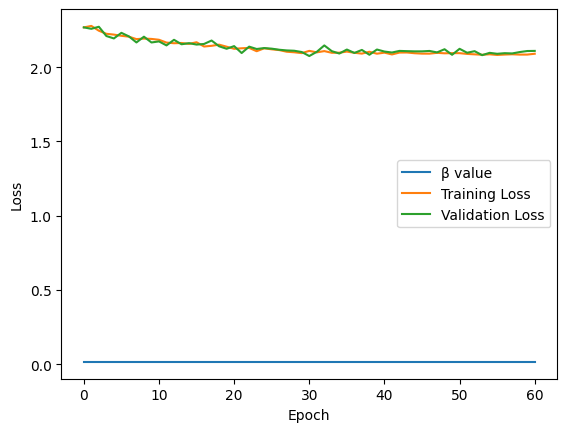

Avarage reconstruction accuracy over 100 runs: 32.19%
KL Divergence on validation data: 0.19539618492126465
KL Divergence on validation data (total): 1.9539618492126465
KL Divergence on validation data (per dimension): [0.15228811 0.42560858 0.17174162 0.13608852 0.2133269  0.2545597
 0.13576466 0.18622363 0.15642108 0.12193903]
KL Divergence on validation data: (1.9539618, array([0.15228811, 0.42560858, 0.17174162, 0.13608852, 0.2133269 ,
       0.2545597 , 0.13576466, 0.18622363, 0.15642108, 0.12193903],
      dtype=float32))
Der Ordner existiert bereits.


In [30]:

def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.2)

# Custom Aktivierungsfunktion r(x)
def custom_activation(x):
    return tf.math.tanh(x) + 1


sum_all_variants = 0
for elem in range(len(dataframes)):
  sum_all_variants = sum_all_variants + dataframes[elem].shape[0]


reconstruction = 0




for Block_ID in range(len(dataframes)):




  data = dataframes[Block_ID].T.values

# Hyperparameter
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
  train_val_ratio = 0.8#  the ratio of how large the training set should be


  # splitting into test and validation data
  train_size = int(train_val_ratio * len(data))
  train_data = data[:train_size]
  val_data = data[train_size:]


  foldername = "Run"                                      #in case one wanst to have multiple training runs you can add the iteration to this name:   foldername = "Run"   + str(iteration_nr)
  experiment_name = "VAE_Demo"                            #name of the experiment
  bottleneck_size = max(1, int(train_data.shape[1]*0.1))   #how large the embedding should be in relationship to the input data:  currently 10%
  latent_dim = bottleneck_size
  batch_size = 256
  epochs = 5000                                           #the maximum number of epochs for training
  patience = 30                                           #after this many epox of no improvement the training will be terminated
  chromosome = 22                                       #part of the folder name structure
  dropout = 0.5                                           #drop outvalue of the dropout layers
  activation_func = leaky_relu
  learn_rate = 1e-4
  gradient_clip_value = 0.25
  fixed_beta = 0.015                                      #currently using fixed beta value
  output_steps = 0                                        # output additional information during training:  0 off , 1 on




  alpha = 1
  beta = 1

  Start_KLAnnealing_Epoch = 1
  Start_value_KLAnnealing = fixed_beta
  epoch_history = []
  beta_history = []

  #this works for online Google collab but change if you want to use locally
  stotage_path =  "C:/Users/HD-ThinkTank/Desktop/Chr" + str(chromosome) + "_models/" + experiment_name + "/"+foldername+ "/" + "Block_ID_" + str(Block_ID) +"/"
  stotage_path_txt =    "C:/Users/HD-ThinkTank/Desktop/Chr" + str(chromosome) +  "_models/" + experiment_name +  "/"+foldername+ "/"

#####No_Settings_after_this_point##########No_Settings_after_this_point##########No_Settings_after_this_point##########No_Settings_after_this_point##########No_Settings_after_this_point#####
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################




  print("##############################################")
  print("Now training block ", Block_ID,"/",len(dataframes)-1)
  print("bottleneck_size: ",bottleneck_size)
  print("Variants: ", train_data.shape[1] )
  print("datapoints: ",train_data.shape[0])
  print("compression:  ",train_data.shape[1]/bottleneck_size)
  print("##############################################")

  # Variational Autoencoder Klasse
  class VAE(keras.Model):
      def __init__(self, latent_dim, dropout_rate=dropout):
          super(VAE, self).__init__()
          self.latent_dim = latent_dim
          self.dropout_rate = dropout_rate
          self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)  # Initial beta value


          self.encoder = tf.keras.Sequential([
              #Input Layer
              layers.InputLayer(input_shape=(data.shape[1],)),

              #Hidden Block
              layers.Dense(int(data.shape[1]), activation=activation_func),
              layers.BatchNormalization(),  # Batch-Normalization-
              layers.Dropout(dropout_rate),

              #Hidden Block
              layers.Dense(int(data.shape[1]*0.5), activation=activation_func),
              layers.BatchNormalization(),  # Batch-Normalization-
              layers.Dropout(dropout_rate),

              #Output Layer
              layers.Dense(latent_dim+latent_dim)
          ])

          self.decoder = tf.keras.Sequential([
              #Input Layer
              layers.InputLayer(input_shape=(latent_dim,)),

              #Hidden Block
              layers.Dense(int(data.shape[1]*0.5), activation=activation_func),
              layers.BatchNormalization(),  # Batch-Normalization

              #Hidden Block
              layers.Dense(int(data.shape[1]), activation=activation_func),
              layers.BatchNormalization(),  # Batch-Normalization

              #Output Layer
              layers.Dense(data.shape[1], activation=custom_activation)
          ])

      def encode(self, x):
          mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
          return mean, logvar

      def reparameterize(self, mean, logvar):
          eps = tf.random.normal(shape=tf.shape(mean))
          return eps * tf.exp(logvar * .5) + mean

      def decode(self, z):
          return self.decoder(z)

      def call(self, x):
          mean, logvar = self.encode(x)
          z = self.reparameterize(mean, logvar)
          x_recon = self.decode(z)
          return x_recon, mean, logvar

  # VAE Modell erstellen
  vae = VAE(latent_dim, dropout)

  # Optimizer definieren mit Gradient Clipping und einstellbarer Lernrate
  optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate, clipvalue=gradient_clip_value)  # Hier kannst du den Clip-Wert anpassen




  # KL-Annealing-Callback definieren
  class KLAnnealingCallback(tf.keras.callbacks.Callback):
    def __init__(self, beta_start= fixed_beta, beta_end=fixed_beta, n_epochs=Start_KLAnnealing_Epoch):
        super(KLAnnealingCallback, self).__init__()
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.n_epochs = n_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.n_epochs:
            new_beta = fixed_beta
            vae.beta.assign(new_beta)
        else:
            #vae.beta.assign(self.beta_end)
            vae.beta.assign(fixed_beta)
            new_beta = fixed_beta# self.beta_end

        beta_history.append(new_beta)
        epoch_history.append(epoch)

  def vae_loss(x, x_recon):
    x_recon, mean, logvar = vae(x)
    recon_loss = tf.keras.losses.MeanSquaredError()(x, x_recon)
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=-1)
    x = tf.cast(x, tf.float32)
    #tf.print("with a beta of ", vae.beta )
    return  recon_loss + vae.beta * kl_loss + 1e-8

  # Modell Checkpoint für die besten Gewichte speichern
  checkpoint_filepath = stotage_path
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      save_best_only=True,
      monitor='val_loss',
      mode='min',
      verbose=0
  )

  # Modell kompilieren
  vae.compile(optimizer=optimizer, loss=vae_loss)

  class CustomEarlyStopping(tf.keras.callbacks.Callback):
      def __init__(self, monitor='val_loss', patience=30, start_epoch=Start_KLAnnealing_Epoch):
          super(CustomEarlyStopping, self).__init__()
          self.monitor = monitor
          self.patience = patience
          self.start_epoch = start_epoch
          self.wait = 0
          self.best = float('inf')

      def on_epoch_end(self, epoch, logs=None):
          current = logs.get(self.monitor)
          if epoch >= self.start_epoch:
              if current < self.best:
                  self.best = current
                  self.wait = 0
              else:
                  self.wait += 1
                  if self.wait >= self.patience:
                      self.model.stop_training = True


  # Modell trainieren mit Early Stopping Callback
  history = vae.fit(train_data, train_data,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_data),
                  callbacks=[model_checkpoint_callback, KLAnnealingCallback(beta_start=Start_value_KLAnnealing), CustomEarlyStopping()],
                  verbose=output_steps)
  #---------------------------------------------------------------------------------------------------
  # Ausgabe des Verlaufs



  plt.plot(epoch_history,beta_history, label='β value')
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Bestes Modell laden
  vae.load_weights(checkpoint_filepath)

  #---------------------------------------------------------------------------------------------------

  num_runs = 100
  total_percentage_correct_reconstruction = 0

  for _ in range(num_runs):
      val_reconstructions, _, _ = vae(val_data)
      mse = tf.keras.losses.MSE(val_data, tf.round(val_reconstructions))
      mean_mse = tf.reduce_mean(mse)
      percentage_correct_reconstruction = (1 - mean_mse) * 100
      total_percentage_correct_reconstruction += percentage_correct_reconstruction

  average_percentage_correct_reconstruction = total_percentage_correct_reconstruction / num_runs
  print(f"Avarage reconstruction accuracy over {num_runs} runs: {average_percentage_correct_reconstruction:.2f}%")

  with open(stotage_path +'Hyperparameter.txt', 'w') as file:
      file.write(f"bottleneck_size: {bottleneck_size}\n")
      file.write(f"Variablen: {train_data.shape[1]}\n")
      file.write(f"epochs: {epochs}\n")
      file.write(f"patience: {patience}\n")
      file.write(f"Block_ID: {Block_ID}\n")
      file.write(f"average_percentage_correct_reconstruction: {average_percentage_correct_reconstruction}\n")

  reconstruction = reconstruction + float(average_percentage_correct_reconstruction * (train_data.shape[1]/sum_all_variants ))




  # Funktion zur Berechnung der KL-Divergenz
  def compute_kl_divergence(mean, logvar):
      return -0.5 * np.mean(1 + logvar - np.square(mean) - np.exp(logvar), axis=-1)

  # Berechnen der KL-Divergenz für die Validierungsdaten
  def evaluate_kl_divergence(model, val_data):
      mean, logvar = model.encode(val_data)
      kl_divergence = compute_kl_divergence(mean.numpy(), logvar.numpy())
      return np.mean(kl_divergence)

  # Berechnen und ausgeben der KL-Divergenz für die Validierungsdaten
  kl_divergence = evaluate_kl_divergence(vae, val_data)
  print(f"KL Divergence on validation data: {kl_divergence}")

  with open(stotage_path +'kl_divergence.txt', 'w') as file:
    file.write(f"reconstruction: {kl_divergence}")



  ####-----------------------------------


  # Funktion zur Berechnung der KL-Divergenz
  def compute_kl_divergence(mean, logvar):
      return -0.5 * (1 + logvar - np.square(mean) - np.exp(logvar))

  # Berechnen der KL-Divergenz für die Validierungsdaten
  def evaluate_kl_divergence(model, val_data):
      mean, logvar = model.encode(val_data)
      kl_divergence_per_dim = compute_kl_divergence(mean.numpy(), logvar.numpy())
      kl_divergence_mean = np.mean(kl_divergence_per_dim, axis=0)
      kl_divergence_total = np.sum(kl_divergence_mean)
      return kl_divergence_total, kl_divergence_mean

  # Berechnen und ausgeben der KL-Divergenz für die Validierungsdaten
  kl_divergence_total, kl_divergence_per_dim = evaluate_kl_divergence(vae, val_data)
  print(f"KL Divergence on validation data (total): {kl_divergence_total}")
  print(f"KL Divergence on validation data (per dimension): {kl_divergence_per_dim}")

  # Berechnen und ausgeben der KL-Divergenz für die Validierungsdaten
  kl_divergence = evaluate_kl_divergence(vae, val_data)
  print(f"KL Divergence on validation data: {kl_divergence}")

  # Daten durch den Encoder leiten, um die latenten Mittelwerte und Log-Varianzen zu erhalten
  mean, logvar = vae.encode(val_data)






def ordner_erstellen(pfad):
  try:
      os.makedirs(pfad)
      print("Ordner erfolgreich erstellt:", pfad)
  except FileExistsError:
      print("Der Ordner existiert bereits.")
  except Exception as e:
      print("Fehler beim Erstellen des Ordners:", e)

# Beispielaufruf der Funktion
ordner_erstellen(stotage_path_txt)

with open(stotage_path_txt +'reconstruction.txt', 'w') as file:
    file.write(f"reconstruction: {reconstruction}")

